In [5]:
import kagglehub # might need to pip install kagglehub
import shutil
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, avg, max, min, countDistinct, sum, round
import geopandas as gpd
import plotly.express as px


# don't run this part still working on it

In [6]:
# Don't 

# Download the dataset to the current directory
try:
    # Replace with the correct dataset identifier
    path = kagglehub.dataset_download("erdi28/zip-codes-demographics")
    print(f"Dataset downloaded to: {path}")

    # Save the dataset as a CSV file in the current directory
    for file_name in os.listdir(path):
        if file_name.endswith(".csv"):
            shutil.move(os.path.join(path, file_name), os.getcwd())
            print(f"CSV file saved to: {os.path.join(os.getcwd(), file_name)}")
except AttributeError as e:
    print("Error: The kagglehub module does not support the method used.")
    print("Please check the documentation or update the library.")
except Exception as e:
    print(f"An error occurred: {e}")

100%|██████████| 2.28M/2.28M [00:00<00:00, 17.2MB/s]

Extracting files...
Dataset downloaded to: /Users/jim/.cache/kagglehub/datasets/erdi28/zip-codes-demographics/versions/3
CSV file saved to: /Users/jim/Projects/p1/ExploreZipCodeData_PySpark/zip_code_demographics.csv


In [7]:
## Set up PySpark environment
from pyspark.sql import SparkSession

In [8]:
## Initialize the SparkSession
# appName is the name of the application
# getOrCreate() creates a new session or retrieves an existing one
spark = SparkSession.builder \
    .appName("ZipCode PySpark Learning") \
        .getOrCreate()

## Verify that SparkSession is created
spark

25/04/18 15:48:53 WARN Utils: Your hostname, Zipcoders-MacBook-Pro-4.local resolves to a loopback address: 127.0.0.1; using 192.168.3.193 instead (on interface en0)
25/04/18 15:48:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/18 15:48:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
try:
    zip_df = spark.read.csv ('./data/zip_code_demographics.csv', header=True, inferSchema=True)
    print('Data loaded successfully')
except Exception as e:
    print(f'Error loading data: {e}')

Data loaded successfully


In [10]:
zip_df.show(10)

+----+--------+---------+------------+--------+-------------+----------+-------+-----------+------+------------------+-------------------+--------------------+----------------+------------------+---------------------+-------------------+-----------------+
| zip|     lat|      lng|        city|state_id|   state_name|population|density|county_name|po_box|      dist_highway|dist2_large_airport|dist2_medium_airport|   dist_to_shore|number_of_business|adjusted_gross_income|total_income_amount|number_of_returns|
+----+--------+---------+------------+--------+-------------+----------+-------+-----------+------+------------------+-------------------+--------------------+----------------+------------------+---------------------+-------------------+-----------------+
|1001|42.06262|-72.62521|      Agawam|      MA|Massachusetts|     16088|  550.1|    Hampden|     0|  1.38703489958776|   106.145765467407|    12.9462123500772|93.0492507357679|               438|               598807|           6047

In [11]:
zip_df.printSchema()

root
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state_id: string (nullable = true)
 |-- state_name: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- density: double (nullable = true)
 |-- county_name: string (nullable = true)
 |-- po_box: integer (nullable = true)
 |-- dist_highway: double (nullable = true)
 |-- dist2_large_airport: double (nullable = true)
 |-- dist2_medium_airport: double (nullable = true)
 |-- dist_to_shore: double (nullable = true)
 |-- number_of_business: integer (nullable = true)
 |-- adjusted_gross_income: integer (nullable = true)
 |-- total_income_amount: double (nullable = true)
 |-- number_of_returns: integer (nullable = true)



## Pop by State -> in state pop by zip

In [12]:
zip_pop_df = zip_df.select('state_id','state_name','population').groupBy('state_id','state_name').agg(sum('population').alias("total_population"))
zip_pop_df.show(10)

+--------+--------------------+----------------+
|state_id|          state_name|total_population|
+--------+--------------------+----------------+
|      MT|             Montana|         1511394|
|      NC|      North Carolina|        12419438|
|      MD|            Maryland|         7224056|
|      CO|            Colorado|         6617159|
|      CT|         Connecticut|         3819343|
|      IL|            Illinois|        13819331|
|      WY|             Wyoming|         1182453|
|      NJ|          New Jersey|         9823423|
|      DE|            Delaware|         1372445|
|      DC|District of Columbia|         1207283|
+--------+--------------------+----------------+
only showing top 10 rows



In [13]:
zip_pop_df.orderBy(col("total_population").desc()).show(5)

+--------+------------+----------------+
|state_id|  state_name|total_population|
+--------+------------+----------------+
|      CA|  California|        44183935|
|      TX|       Texas|        33411444|
|      NY|    New York|        23903874|
|      FL|     Florida|        23007226|
|      PA|Pennsylvania|        16557706|
+--------+------------+----------------+
only showing top 5 rows



In [14]:
zip_pop_pd = zip_pop_df.toPandas()

In [15]:
shape_path = './data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp'
shape = gpd.read_file(shape_path)
print(shape.columns)

Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry'],
      dtype='object')


In [16]:
shape_for_graph = pd.merge(
    left = shape,
    right = zip_pop_pd,
    left_on = 'NAME',
    right_on ='state_name',
    how = 'left'
)

In [17]:
shape_for_graph = shape_for_graph.dropna()


In [18]:
shape_for_graph = shape_for_graph[~shape_for_graph['NAME'].isin(['Alaska', 'Hawaii','Puerto Rico'])]

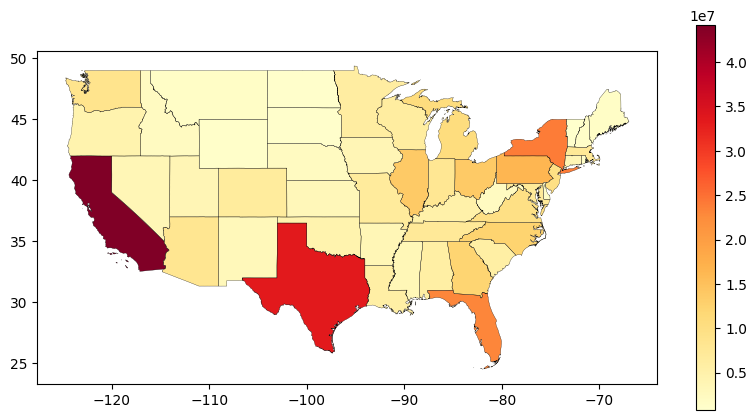

In [19]:
ax = shape_for_graph.boundary.plot(edgecolor ='black', linewidth=0.2, figsize=(10,5))
shape_for_graph.plot(ax=ax, column="total_population", legend=True, cmap='YlOrRd')
plt.show()

## AGI by buisness by zip

Make a dataset of only values pertaining to desired calculations.

In [20]:
df_limited= zip_df[['zip', 'city', 'state_id', 'number_of_business', 'adjusted_gross_income', 'total_income_amount']]

In [21]:
df_limited.printSchema()

root
 |-- zip: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- state_id: string (nullable = true)
 |-- number_of_business: integer (nullable = true)
 |-- adjusted_gross_income: integer (nullable = true)
 |-- total_income_amount: double (nullable = true)



In [22]:
numeric_cols = [c for c, t in df_limited.dtypes if t.startswith('string')==False]
df_limited.select(*numeric_cols).summary().show()

25/04/18 15:49:22 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------------+---------------------+-------------------+
|summary|              zip|number_of_business|adjusted_gross_income|total_income_amount|
+-------+-----------------+------------------+---------------------+-------------------+
|  count|            33704|             33624|                33704|              33704|
|   mean|49842.60782103014| 260.6949202950274|   425134.10239140753| 429894.33857557003|
| stddev|27451.11144214845|432.11281369671184|    756151.9395034771|  764441.5938419583|
|    min|             1001|                 1|                  577|              577.0|
|    25%|            27051|                19|                32471|         32873.0001|
|    50%|            49776|                74|               112840|           114006.0|
|    75%|            72206|               333|               505154|           509227.0|
|    max|            99929|              7263|             15224673|        1.5277982E7|
+-------+------------

Reviewing of data showed instances of number of businesses being null.

In [23]:
print(33704-33624)
df_limited.filter(col('number_of_business').isNull()).show()

80
+-----+--------------+--------+------------------+---------------------+-------------------+
|  zip|          city|state_id|number_of_business|adjusted_gross_income|total_income_amount|
+-----+--------------+--------+------------------+---------------------+-------------------+
|12115| Malden Bridge|      NY|              NULL|                19103|         19154.0002|
|14819|       Cameron|      NY|              NULL|                12293|         12320.0002|
|15429|         Denbo|      PA|              NULL|                 4667|             4667.0|
|16691| Wells Tannery|      PA|              NULL|                 8832|          8858.0004|
|20606|         Abell|      MD|              NULL|                12492|         12533.0002|
|22504|      Laneview|      VA|              NULL|                 6260|          6292.0003|
|23068|    Hallieford|      VA|              NULL|                 8923|          8956.0002|
|23488|       Withams|      VA|              NULL|                 

For the purposes of AGI in relation to number of businesses generated a dataset dropping instances of no businesses being recorded.

In [24]:
df_AGI_v_Business = df_limited.na.drop(subset=['number_of_business'])

In [25]:
numeric_cols = [c for c, t in df_AGI_v_Business.dtypes if t.startswith('string')==False]
df_AGI_v_Business.select(*numeric_cols).summary().show()

+-------+------------------+------------------+---------------------+-------------------+
|summary|               zip|number_of_business|adjusted_gross_income|total_income_amount|
+-------+------------------+------------------+---------------------+-------------------+
|  count|             33624|             33624|                33624|              33624|
|   mean|49841.581251487034| 260.6949202950274|     426128.850672139|  430900.3270977903|
| stddev|27464.851381954184|432.11281369671184|    756775.5571880672|  765071.8628725683|
|    min|              1001|                 1|                  577|              577.0|
|    25%|             27046|                19|                32769|            33180.0|
|    50%|             49781|                74|               113622|           115128.0|
|    75%|             72223|               333|               505229|           510234.0|
|    max|             99929|              7263|             15224673|        1.5277982E7|
+-------+-

Generate new column to show AGI per Business.

In [26]:
df_AGI_v_Business = df_AGI_v_Business.select("*", (col("adjusted_gross_income") / col("number_of_business")).alias("AGI per Business"))

In [27]:
df_AGI_v_Business.printSchema()

root
 |-- zip: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- state_id: string (nullable = true)
 |-- number_of_business: integer (nullable = true)
 |-- adjusted_gross_income: integer (nullable = true)
 |-- total_income_amount: double (nullable = true)
 |-- AGI per Business: double (nullable = true)



In [28]:
numeric_cols = [c for c, t in df_AGI_v_Business.dtypes if t.startswith('string')==False]
df_AGI_v_Business.select(*numeric_cols).summary().show()

+-------+------------------+------------------+---------------------+-------------------+------------------+
|summary|               zip|number_of_business|adjusted_gross_income|total_income_amount|  AGI per Business|
+-------+------------------+------------------+---------------------+-------------------+------------------+
|  count|             33624|             33624|                33624|              33624|             33624|
|   mean|49841.581251487034| 260.6949202950274|     426128.850672139|  430900.3270977903|2020.7699515399624|
| stddev|27464.851381954184|432.11281369671184|    756775.5571880672|  765071.8628725683|1680.3575191855648|
|    min|              1001|                 1|                  577|              577.0|12.113924050632912|
|    25%|             27046|                19|                32769|            33180.0| 1086.376811594203|
|    50%|             49781|                74|               113622|           115128.0|1639.2309941520468|
|    75%|          

In order to plot needed to convert to pandas.

In [29]:
pandas_df = df_AGI_v_Business.toPandas()

In [30]:
pandas_df['AGI per Business'].describe()

count    33624.000000
mean      2020.769952
std       1680.357519
min         12.113924
25%       1086.376812
50%       1639.273140
75%       2450.263251
max      84963.500000
Name: AGI per Business, dtype: float64

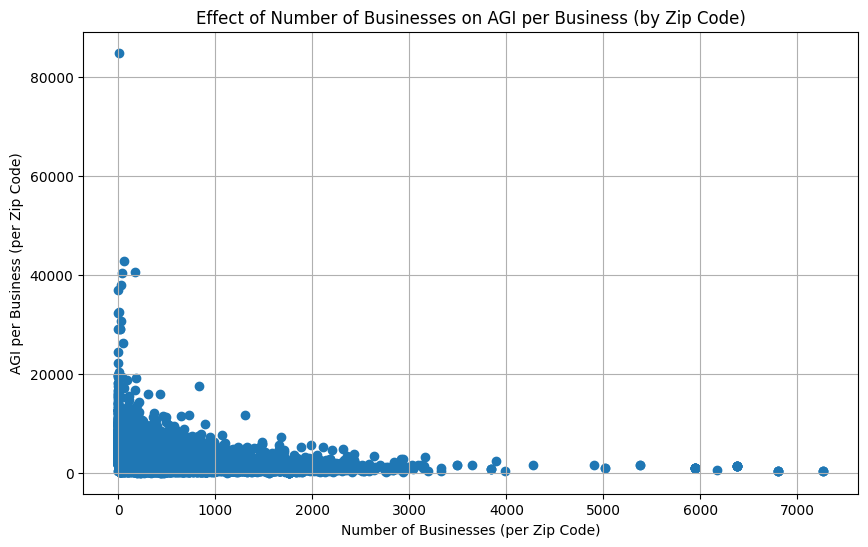

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['number_of_business'], pandas_df['AGI per Business'])
plt.xlabel("Number of Businesses (per Zip Code)")
plt.ylabel("AGI per Business (per Zip Code)")
plt.title("Effect of Number of Businesses on AGI per Business (by Zip Code)")
plt.grid(True)
plt.show()

Decided to generate a plot graph that could be hovered over to investigate results.

In [32]:
fig = px.scatter(pandas_df,
                 x='number_of_business',
                 y='AGI per Business',
                 hover_data=['number_of_business', 'AGI per Business', 'zip'], # Add other columns to display on hover
                 labels={'number_of_business': 'Number of Businesses (per Zip Code)',
                         'AGI per Business': 'AGI per Business (per Zip Code)'},
                 title='Effect of Number of Businesses on AGI per Business (by Zip Code)')
fig.show()

The values shown for number of businesses when looking into outlying instances zip code 80297 (Colorado Springs, Colorado) having 4 businesses and 10199 (New York, New York) having 7263 businesses led me to want to delve deeper into those locations as the data seemed off. I decided to review the sources used in the creation of this dataset at https://github.com/erkara/auc-data-challenge-23/blob/main/data_sources.xlsx. There it indicated the values are pulled from realdatasets.com for the year of 2012. US Census Bureau states 12 establishments for 10199 in 2012 (https://data.census.gov/profile?q=2012+zip+code+business&g=010XX00US$8600000_860XX00US10199&y=2012). While 80297 does not appear in the 2012 census data.      

## AGI by total income by zip 

In [33]:
numeric_cols = [c for c, t in df_limited.dtypes if t.startswith('string')==False]
df_limited.select(*numeric_cols).summary().show()

+-------+-----------------+------------------+---------------------+-------------------+
|summary|              zip|number_of_business|adjusted_gross_income|total_income_amount|
+-------+-----------------+------------------+---------------------+-------------------+
|  count|            33704|             33624|                33704|              33704|
|   mean|49842.60782103014| 260.6949202950274|   425134.10239140753| 429894.33857557003|
| stddev|27451.11144214845|432.11281369671184|    756151.9395034771|  764441.5938419583|
|    min|             1001|                 1|                  577|              577.0|
|    25%|            27051|                19|                32471|         32873.0001|
|    50%|            49776|                74|               112840|           114006.0|
|    75%|            72206|               333|               505154|           509227.0|
|    max|            99929|              7263|             15224673|        1.5277982E7|
+-------+------------

Create a new dataset where the AGI is below the mean and the total income is above the mean.

In [34]:
filtered_df = df_limited.filter(col("adjusted_gross_income") < 425134.10239140753)
filtered_df = filtered_df.filter(col("total_income_amount") > 429894.33857557003)

In [35]:
numeric_cols = [c for c, t in filtered_df.dtypes if t.startswith('string')==False]
filtered_df.select(*numeric_cols).summary().show()

+-------+-----------------+------------------+---------------------+-------------------+
|summary|              zip|number_of_business|adjusted_gross_income|total_income_amount|
+-------+-----------------+------------------+---------------------+-------------------+
|  count|               11|                11|                   11|                 11|
|   mean|61758.72727272727|505.27272727272725|   424454.36363636365|  431883.8181818182|
| stddev|35880.84149261528|  295.339157887704|   355.43699096387456| 1227.7339140206066|
|    min|             4046|               192|               423630|           430086.0|
|    25%|            19031|               328|               424278|           430561.0|
|    50%|            79360|               499|               424488|           431912.0|
|    75%|            90013|               521|               424805|           432930.0|
|    max|            99663|              1317|               424876|           433893.0|
+-------+------------

In [36]:
filtered_df.show()

+-----+--------------+--------+------------------+---------------------+-------------------+
|  zip|          city|state_id|number_of_business|adjusted_gross_income|total_income_amount|
+-----+--------------+--------+------------------+---------------------+-------------------+
| 4046| Kennebunkport|      ME|               328|               424805|           433893.0|
| 7727|   Farmingdale|      NJ|               401|               423630|           430561.0|
|19031|     Flourtown|      PA|               192|               424876|           431616.0|
|53959|     Reedsburg|      WI|               328|               424844|           430086.0|
|63501|    Kirksville|      MO|               616|               424355|           431049.0|
|79360|      Seminole|      TX|               336|               424311|           431912.0|
|81201|        Salida|      CO|               499|               424488|           432930.0|
|90013|   Los Angeles|      CA|              1317|               42464

The above table shows the results but variation between the zipcodes is minimal when the application of removing above mean AGI and below mean total income leading to no value to visual plot. 

## AGI by Population

In [37]:
df_limited_AGI_Pop= zip_df[['zip', 'city', 'state_id', 'population', 'adjusted_gross_income']]

In [38]:
numeric_cols = [c for c, t in df_limited_AGI_Pop.dtypes if t.startswith('string')==False]
df_limited_AGI_Pop.select(*numeric_cols).summary().show()

+-------+-----------------+------------------+---------------------+
|summary|              zip|        population|adjusted_gross_income|
+-------+-----------------+------------------+---------------------+
|  count|            33704|             33704|                33704|
|   mean|49842.60782103014|11287.959737716592|   425134.10239140753|
| stddev|27451.11144214845|15200.216997387142|    756151.9395034771|
|    min|             1001|                 0|                  577|
|    25%|            27051|              1253|                32471|
|    50%|            49776|              4099|               112840|
|    75%|            72206|             16104|               505154|
|    max|            99929|            130352|             15224673|
+-------+-----------------+------------------+---------------------+



In [39]:
df_limited_AGI_Pop_sorted = df_limited_AGI_Pop.sort('population')

In [40]:
pandas_AGI_Pop_df = df_limited_AGI_Pop_sorted.toPandas()

In [41]:
fig = px.scatter(pandas_AGI_Pop_df,
                 x='population',
                 y='adjusted_gross_income',
                 hover_data=['population', 'adjusted_gross_income', 'zip'], # Add other columns to display on hover
                 labels={'population': 'Population (per Zip Code)',
                         'adjusted_gross_income': 'AGI per (per Zip Code)'},
                 title='Effect of Population on Adjusted Gross Income (by Zip Code)')
fig.show()

The scatter plot above shows that the AGI for a zip code does increase with population yet not a 1 to 1 result. There are too many outliers that show a much greater AGI indepentant of population.

## AGI by shore

## airport shore nuber of business zipcode

## number of returns by county

## Distance highway/airport Pop by zipcode